# Model Optimization

Notebook for optimizing tested models

### Imports

In [1]:
from utils.EDA_utils import *
from utils.utils import get_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GroupKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
import dalex as dx
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Main Training Loop

### Data Import

In [3]:
EE15 = get_dataset("data/", samples=["EE_015"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE50 = get_dataset("data/", samples=["EE_050"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)
EE69 = get_dataset("data/", samples=["EE_069"], file_type="both", option_csq="potential", 
            options_genotype=["potential", "all"], with_default=True)

In [4]:
EE15['patient'] = 'EE15'
EE50['patient'] = 'EE50'
EE69['patient'] = 'EE69'

In [5]:
custom_mapping = {
    'Benign': 0,
    'Likely%40Benign': 1,
    'Uncertain%40Significance': 2,
    'Likely%40Pathogenic': 3,
    'Pathogenic': 4
}

target_column = "ACMG_class"
df = pd.concat([EE15, EE50, EE69])

df = df.loc[:, ~df.columns.duplicated()]
preprocessed_df = preprocess(df)

encoded_df, encoders, target_mapping = encode(preprocessed_df, target_column, custom_mapping)

In [6]:
def invert_dict(original_dict):
    inverted_dict = {v: k for k, v in original_dict.items()}
    return inverted_dict

In [7]:
def count_unique(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    for value, count in zip(unique_values, counts):
        print(f"Value {value} occurs {count} times.")

In [8]:
inverted_mapping = invert_dict(target_mapping)

### Cost Matrixes

In [9]:
cost_matrix = np.array([
    [0, 1, 3, 5, 6], #B
    [1, 0, 3, 5, 6], #LB
    [5, 3, 0, 1, 2], #US
    [10, 7, 3, 0, 1], #LP
    [12, 10, 3, 1, 0]  #P
], dtype = np.float64)

In [10]:
class_weights = []
for i in range(5):
    count = encoded_df["ACMG_class"].value_counts().get(i, 0)
    class_weights.append(count)
class_weights = np.array(class_weights, dtype=np.float64)
class_weights -= np.sum(class_weights)
class_weights *= (-1)
class_weights /= np.max(class_weights)
weighted_cost_matrix = cost_matrix * class_weights[:, np.newaxis]
weighted_cost_matrix

array([[ 0.        ,  0.13464403,  0.4039321 ,  0.67322016,  0.80786419],
       [ 0.94215944,  0.        ,  2.82647831,  4.71079718,  5.65295661],
       [ 4.61906551,  2.77143931,  0.        ,  0.9238131 ,  1.84762621],
       [ 9.99833481,  6.99883437,  2.99950044,  0.        ,  0.99983348],
       [12.        , 10.        ,  3.        ,  1.        ,  0.        ]])

In [11]:
def custom_loss_func(y_true, y_pred):
    return np.sum(cost_matrix[y_true, y_pred])

def custom_loss_func_weighted(y_true, y_pred):
    return np.sum(weighted_cost_matrix[y_true, y_pred])

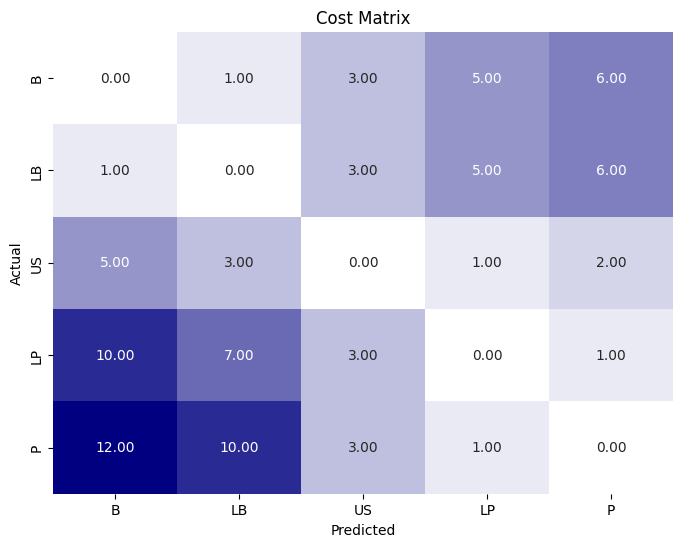

In [12]:
class_names = ['B', 'LB', 'US', 'LP', 'P']

colors = [(1, 1, 1), (0, 0, 0.5)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title('Cost Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

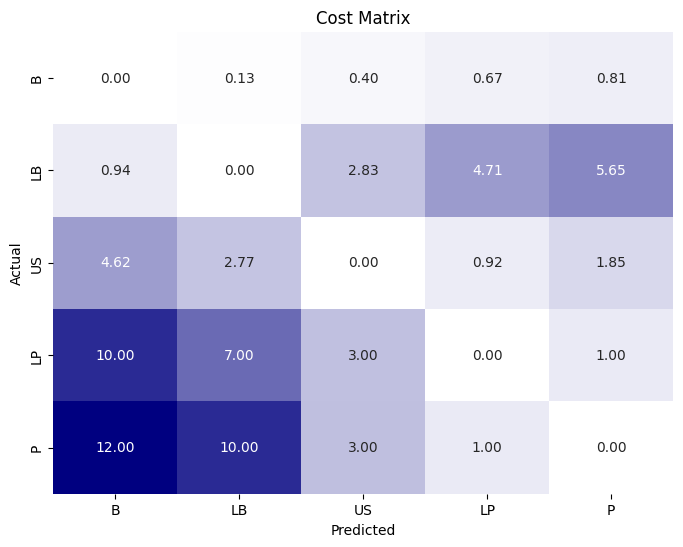

In [13]:
class_names = ['B', 'LB', 'US', 'LP', 'P']

colors = [(1, 1, 1), (0, 0, 0.5)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_cost_matrix, annot=True, fmt=".2f", cmap=cmap,
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title('Cost Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Training

#### Logistic Regression

Fitting Model with unweighted loss, greater==better: True, None
Best Parameters:  {'max_iter': 300, 'penalty': None, 'solver': 'newton-cg'}
Best Custom Score:  356214.6666666667
Confusion Matrix:


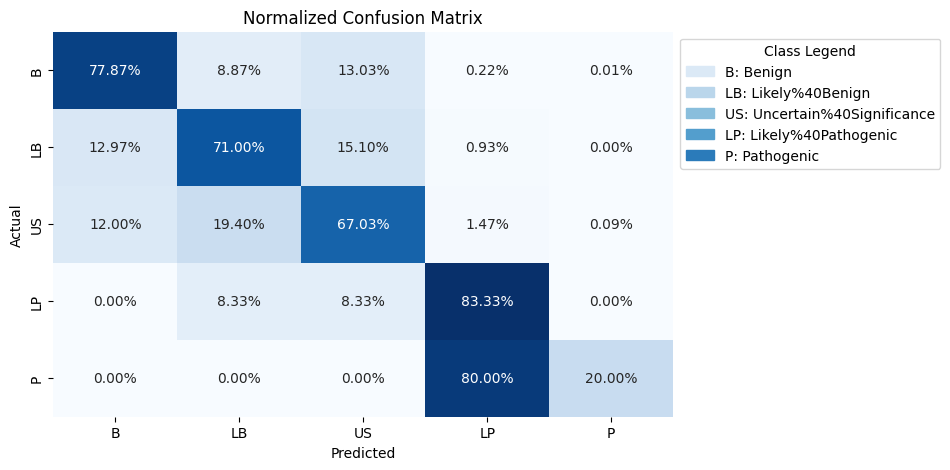

Fitting Model with unweighted loss, greater==better: False, None
Best Parameters:  {'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Custom Score:  -67309.0
Confusion Matrix:


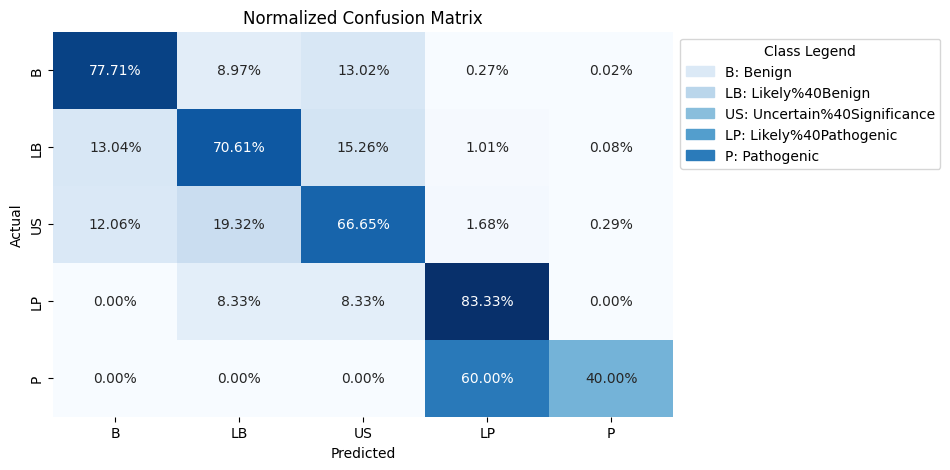

Fitting Model with weighted loss, greater==better: True, None
Best Parameters:  {'max_iter': 300, 'penalty': None, 'solver': 'newton-cg'}
Best Custom Score:  74603.22155039595
Confusion Matrix:


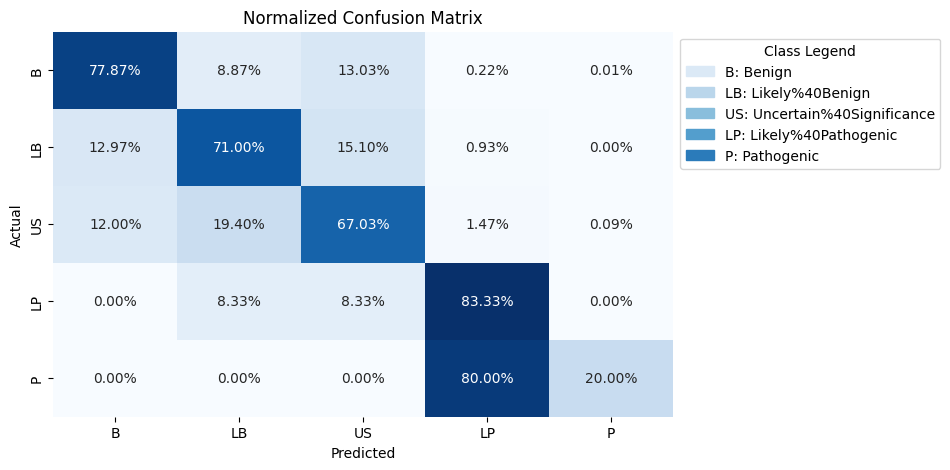

Fitting Model with weighted loss, greater==better: False, None
Best Parameters:  {'max_iter': 200, 'penalty': None, 'solver': 'saga'}
Best Custom Score:  -37867.13500932356
Confusion Matrix:


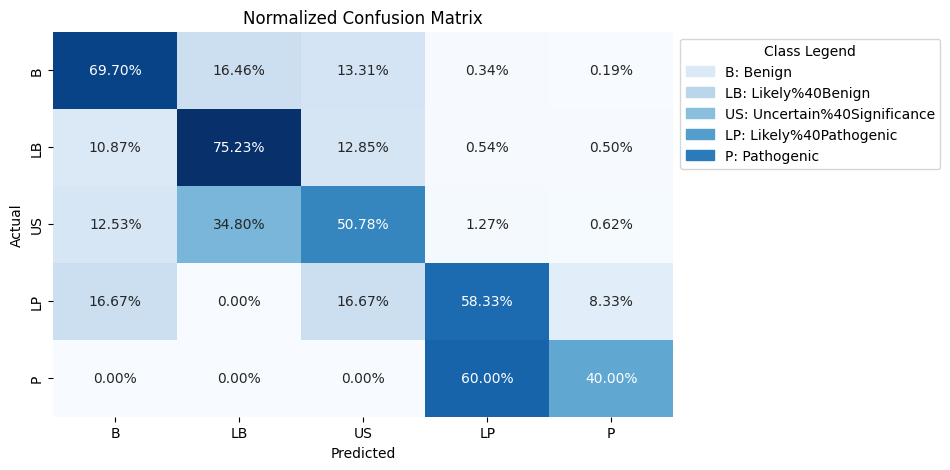

Fitting Model with unweighted loss, greater==better: True, Random OverSampler
Best Parameters:  {'max_iter': 300, 'penalty': None, 'solver': 'newton-cg'}
Best Custom Score:  327577.6666666667
Confusion Matrix:


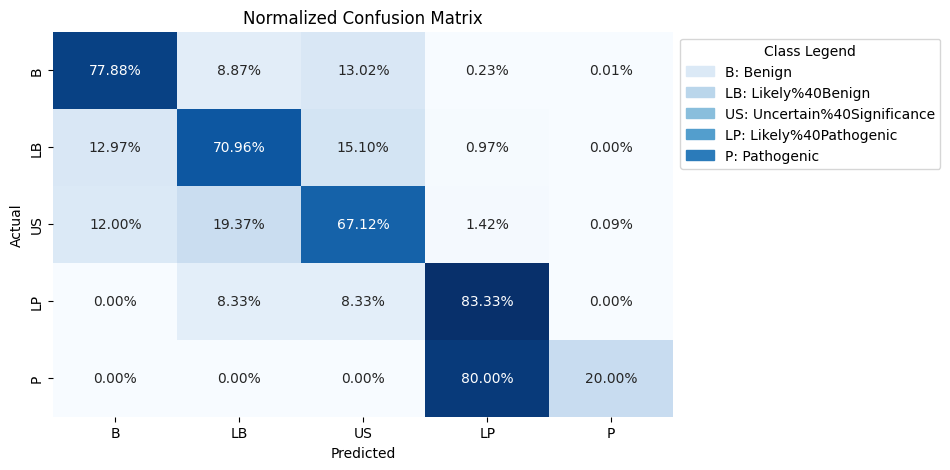

Fitting Model with unweighted loss, greater==better: False, Random OverSampler
Best Parameters:  {'max_iter': 20, 'penalty': None, 'solver': 'saga'}
Best Custom Score:  -60047.666666666664
Confusion Matrix:


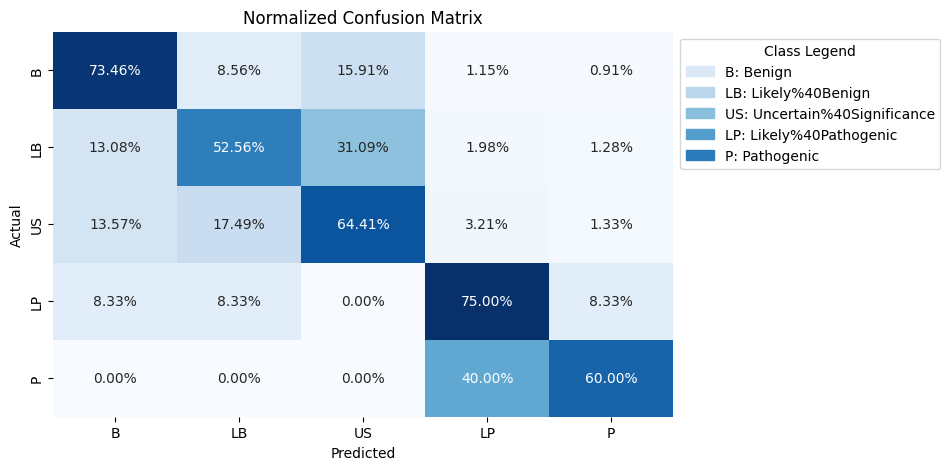

Fitting Model with weighted loss, greater==better: True, Random OverSampler


In [14]:
encoded_df = encoded_df.drop_duplicates()
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]
greater_better = False

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), None),
]

param_grid = {
    'penalty': ['l2', 'elasticnet', None],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [5, 20, 100, 200, 300]
}

for method_name, method, neighborhood_cleaning in methods:
    for loss_name, my_loss in losses:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")
            
        X = encoded_df.drop(columns = [target_column])
        y = encoded_df[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
        X_test = X_test.drop(columns = ['patient'])
        X_val = X_val.drop(columns = ['patient'])

        patient_column_index = X_train.columns.get_loc('patient')
        columns_to_exclude = [patient_column_index]

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = LogisticRegression(class_weight=dict(enumerate(class_weights)), random_state=42)

        columns_to_scale = np.ones(len(X_train.columns), dtype=bool)
        columns_to_scale[columns_to_exclude] = False
        scaler = MinMaxScaler()
        X_train.loc[:, columns_to_scale] = scaler.fit_transform(X_train.loc[:, columns_to_scale])
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train
            groups = X_resampled_cleaned["patient"]
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            groups = X_resampled_cleaned["patient"]
            groups = groups.astype(int)
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)
            groups = X_resampled_cleaned["patient"]
            groups = groups.astype(int)
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

        group_kfold = GroupKFold(n_splits=3)
        grid_search = GridSearchCV(classifier, param_grid, scoring=custom_scorer, cv=group_kfold)
        grid_search.fit(X_resampled_cleaned, y_resampled_cleaned, groups=groups)

        print("Best Parameters: ", grid_search.best_params_)
        print("Best Custom Score: ", grid_search.best_score_)
        print("Confusion Matrix:")

        best_params = grid_search.best_params_
        best_classifier = LogisticRegression(**best_params, class_weight=dict(enumerate(class_weights)), random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

#### AdaBoost

In [ ]:
encoded_df = encoded_df.drop_duplicates()
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

greater_better = False
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), None),
]

param_grid = {
    'n_estimators': [5, 10, 20, 50, 70, 100, 200],
    'learning_rate': [0.5, 1.0, 2.0]
}

for loss_name, my_loss in losses:
    for method_name, method, neighborhood_cleaning in methods:
        print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")
            
        X = encoded_df.drop(columns = [target_column])
        y = encoded_df[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
        X_test = X_test.drop(columns = ['patient'])
        X_val = X_val.drop(columns = ['patient'])

        patient_column_index = X_train.columns.get_loc('patient')
        columns_to_exclude = [patient_column_index]

        custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        classifier = AdaBoostClassifier(random_state=42)

        columns_to_scale = np.ones(len(X_train.columns), dtype=bool)
        columns_to_scale[columns_to_exclude] = False
        scaler = MinMaxScaler()
        X_train.loc[:, columns_to_scale] = scaler.fit_transform(X_train.loc[:, columns_to_scale])
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        if method_name == 'None':
            X_resampled_cleaned, y_resampled_cleaned = X_train, y_train
            groups = X_resampled_cleaned["patient"]
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

        elif method_name == "SMOTE with cleaning":
            X_resampled, y_resampled = method.fit_resample(X_train, y_train)
            X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
            groups = X_resampled_cleaned["patient"]
            groups = groups.astype(int)
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])
            
        else:
            X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)
            groups = X_resampled_cleaned["patient"]
            groups = groups.astype(int)
            X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

        group_kfold = GroupKFold(n_splits=3)
        grid_search = GridSearchCV(classifier, param_grid, scoring=custom_scorer, cv=group_kfold)
        grid_search.fit(X_resampled_cleaned, y_resampled_cleaned, groups=groups)

        print("Best Parameters: ", grid_search.best_params_)
        print("Best Custom Score: ", grid_search.best_score_)
        print("Confusion Matrix:")

        best_params = grid_search.best_params_
        best_classifier = LogisticRegression(**best_params, class_weight=dict(enumerate(class_weights)), random_state=42)
        best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
        y_pred = best_classifier.predict(X_val)
        get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

Fitting Model with unweighted loss, greater==better: True, None


TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'sample_weight'

#### CatBoost

In [ ]:
encoded_df = encoded_df.drop_duplicates()
losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]

scorrer_optimize = [True, False]
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler" , RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), None),
]

param_grid = {
    'depth': [4, 6, 8, 16],
    'learning_rate': [0.03, 0.3, 0.5],
    'iterations': [50, 100, 500, 1000],
}

for loss_name, my_loss in losses:
    for greater_better in scorrer_optimize:
        for method_name, method, neighborhood_cleaning in methods:
            print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")
            
            X = encoded_df.drop(columns = [target_column])
            y = encoded_df[target_column]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
            X_test = X_test.drop(columns = ['patient'])
            X_val = X_val.drop(columns = ['patient'])

            patient_column_index = X_train.columns.get_loc('patient')
            columns_to_exclude = [patient_column_index]

            custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            classifier = CatBoostClassifier(class_weights=dict(enumerate(class_weights)), random_state=42, verbose=False)

            columns_to_scale = np.ones(len(X_train.columns), dtype=bool)
            columns_to_scale[columns_to_exclude] = False
            scaler = MinMaxScaler()
            X_train.loc[:, columns_to_scale] = scaler.fit_transform(X_train.loc[:, columns_to_scale])
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            if method_name == 'None':
                 X_resampled_cleaned, y_resampled_cleaned = X_train, y_train
                 groups = X_resampled_cleaned["patient"]
                 X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

            elif method_name == "SMOTE with cleaning":
                X_resampled, y_resampled = method.fit_resample(X_train, y_train)
                X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
                groups = X_resampled_cleaned["patient"]
                groups = groups.astype(int)
                X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])
            
            else:
                X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)
                groups = X_resampled_cleaned["patient"]
                groups = groups.astype(int)
                X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

            group_kfold = GroupKFold(n_splits=3)
            grid_search = GridSearchCV(classifier, param_grid, scoring=custom_scorer, cv=group_kfold)
            grid_search.fit(X_resampled_cleaned, y_resampled_cleaned, groups=groups)

            print("Best Parameters: ", grid_search.best_params_)
            print("Best Custom Score: ", grid_search.best_score_)
            print("Confusion Matrix:")

            best_params = grid_search.best_params_
            best_classifier = LogisticRegression(**best_params, class_weight=dict(enumerate(class_weights)), random_state=42)
            best_classifier.fit(X_resampled_cleaned, y_resampled_cleaned)
            y_pred = best_classifier.predict(X_val)
            get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

Fitting Model with unweighted loss, greater==better: True, None


d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "d:\pathogenicity_project\pathogenicity\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\mateu\AppData\Local\Temp\ipykernel_11860\69467695.py", line 2, in custom_loss_func
    return np.sum(cost_matrix[y_true, y_pred])
numpy.core._exceptions._ArrayMemory

#### Ensamble

In [ ]:
encoded_df = encoded_df.drop_duplicates()

losses = [("unweighted", custom_loss_func), ("weighted", custom_loss_func_weighted)]
scorrer_optimize = [True, False]
classes_to_oversample = [3, 4]
classes_to_undersample = [0]
undersampling_ratios = [200000]
sampling_ratios = [150, 60]

methods = [
    ("None", None, None),
    ("Random OverSampler", RandomOverSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), None),
    ("SMOTE with cleaning", SMOTE(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_oversample, sampling_ratios)}, random_state=42), NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=7)),
    ("Random UnderSampling", RandomUnderSampler(sampling_strategy={class_label: ratio for class_label, ratio in zip(classes_to_undersample, undersampling_ratios)}, random_state=42), None),
]

param_grid = {
    'n_estimators': [5, 10, 20, 50, 100]
}

for loss_name, my_loss in losses:
    for greater_better in scorrer_optimize:
        for method_name, method, neighborhood_cleaning in methods:
            print(f"Fitting Model with {loss_name} loss, greater==better: {greater_better}, {method_name}")

            X = encoded_df.drop(columns=[target_column])
            y = encoded_df[target_column]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
            X_test = X_test.drop(columns=['patient'])
            X_val = X_val.drop(columns=['patient'])

            patient_column_index = X_train.columns.get_loc('patient')
            columns_to_exclude = [patient_column_index]

            custom_scorer = make_scorer(my_loss, greater_is_better=greater_better)
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            classifier = EasyEnsembleClassifier(random_state=42)

            columns_to_scale = np.ones(len(X_train.columns), dtype=bool)
            columns_to_scale[columns_to_exclude] = False
            scaler = MinMaxScaler()
            X_train.loc[:, columns_to_scale] = scaler.fit_transform(X_train.loc[:, columns_to_scale])
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(X_test)

            if method_name == 'None':
                X_resampled_cleaned, y_resampled_cleaned = X_train, y_train
                groups = X_resampled_cleaned["patient"]
                X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])
            elif method_name == "SMOTE with cleaning":
                X_resampled, y_resampled = method.fit_resample(X_train, y_train)
                X_resampled_cleaned, y_resampled_cleaned = neighborhood_cleaning.fit_resample(X_resampled, y_resampled)
                groups = X_resampled_cleaned["patient"]
                groups = groups.astype(int)
                X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])
            else:
                X_resampled_cleaned, y_resampled_cleaned = method.fit_resample(X_train, y_train)
                groups = X_resampled_cleaned["patient"]
                groups = groups.astype(int)
                X_resampled_cleaned = X_resampled_cleaned.drop(columns=["patient"])

            group_kfold = GroupKFold(n_splits=3)
            grid_search = GridSearchCV(EasyEnsembleClassifier(), param_grid, scoring=custom_scorer, cv=group_kfold)
            grid_search.fit(X_resampled_cleaned, y_resampled_cleaned, groups=groups)

            print("Best Parameters: ", grid_search.best_params_)
            print("Best Custom Score: ", grid_search.best_score_)
            print("Confusion Matrix:")

            best_params = grid_search.best_params_
            best_ensemble_clf = EasyEnsembleClassifier(**best_params, random_state=42)
            best_ensemble_clf.fit(X_resampled_cleaned, y_resampled_cleaned)
            y_pred = best_ensemble_clf.predict(X_val)
            get_confusion_matrix_plot(y_val, y_pred, inverted_mapping)

Fitting Model with unweighted loss, greater==better: True, None


KeyboardInterrupt: 

### Final Model

# TODO: Once final model is chosen, teach it on all the data and the test and evaluate it